In [3]:
import numpy as np 
import pandas as pd 
import os
import json
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import Sequential, Model 
from tensorflow.keras.layers import Dense, LSTM, Input, Masking, Activation, Dropout, Concatenate
from tensorflow.keras.layers import Flatten, MultiHeadAttention, LayerNormalization
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.optimizers.experimental import AdamW
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from keras.utils import to_categorical
from keras.regularizers import l1, l2

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [4]:
pip install mediapipe

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.9/33.9 MB 31.3 MB/s eta 0:00:0000:0100:01
Note: you may need to restart the kernel to use updated packages.


In [5]:
## loading train.csv data

train_df = pd.read_csv('/kaggle/input/asl-signs/train.csv')
train_df.head()

,path,participant_id,sequence_id,sign
0,train_landmark_files/26734/1000035562.parquet,26734,1000035562,blow
1,train_landmark_files/28656/1000106739.parquet,28656,1000106739,wait
2,train_landmark_files/16069/100015657.parquet,16069,100015657,cloud
3,train_landmark_files/25571/1000210073.parquet,25571,1000210073,bird
4,train_landmark_files/62590/1000240708.parquet,62590,1000240708,owie


In [6]:
train_df.tail()

,path,participant_id,sequence_id,sign
94472,train_landmark_files/53618/999786174.parquet,53618,999786174,white
94473,train_landmark_files/26734/999799849.parquet,26734,999799849,have
94474,train_landmark_files/25571/999833418.parquet,25571,999833418,flower
94475,train_landmark_files/29302/999895257.parquet,29302,999895257,room
94476,train_landmark_files/36257/999962374.parquet,36257,999962374,happy


In [7]:
len(train_df)   ## number of videos 

94477

In [8]:
## loading sign index map 
json_file = open('/kaggle/input/asl-signs/sign_to_prediction_index_map.json')
sign_label = json.load(json_file)  ## a dictionary variable with all labels and its integer representation
n_signs = len(sign_label)
n_signs  ## number of classes

250

In [6]:
sign_label

{'TV': 0,
 'after': 1,
 'airplane': 2,
 'all': 3,
 'alligator': 4,
 'animal': 5,
 'another': 6,
 'any': 7,
 'apple': 8,
 'arm': 9,
 'aunt': 10,
 'awake': 11,
 'backyard': 12,
 'bad': 13,
 'balloon': 14,
 'bath': 15,
 'because': 16,
 'bed': 17,
 'bedroom': 18,
 'bee': 19,
 'before': 20,
 'beside': 21,
 'better': 22,
 'bird': 23,
 'black': 24,
 'blow': 25,
 'blue': 26,
 'boat': 27,
 'book': 28,
 'boy': 29,
 'brother': 30,
 'brown': 31,
 'bug': 32,
 'bye': 33,
 'callonphone': 34,
 'can': 35,
 'car': 36,
 'carrot': 37,
 'cat': 38,
 'cereal': 39,
 'chair': 40,
 'cheek': 41,
 'child': 42,
 'chin': 43,
 'chocolate': 44,
 'clean': 45,
 'close': 46,
 'closet': 47,
 'cloud': 48,
 'clown': 49,
 'cow': 50,
 'cowboy': 51,
 'cry': 52,
 'cut': 53,
 'cute': 54,
 'dad': 55,
 'dance': 56,
 'dirty': 57,
 'dog': 58,
 'doll': 59,
 'donkey': 60,
 'down': 61,
 'drawer': 62,
 'drink': 63,
 'drop': 64,
 'dry': 65,
 'dryer': 66,
 'duck': 67,
 'ear': 68,
 'elephant': 69,
 'empty': 70,
 'every': 71,
 'eye': 72,
 

In [9]:
## understanding parquet data for one sign example given

pq_path = os.path.join('/kaggle/input/asl-signs',train_df['path'][0])   ## taking first data in df
pq_df = pd.read_parquet(pq_path)
pq_df

,frame,row_id,type,landmark_index,x,y,z
0,20,20-face-0,face,0,0.494400,0.380470,-0.030626
1,20,20-face-1,face,1,0.496017,0.350735,-0.057565
2,20,20-face-2,face,2,0.500818,0.359343,-0.030283
3,20,20-face-3,face,3,0.489788,0.321780,-0.040622
4,20,20-face-4,face,4,0.495304,0.341821,-0.061152
...,...,...,...,...,...,...,...
12484,42,42-right_hand-16,right_hand,16,0.001660,0.549574,-0.145409
12485,42,42-right_hand-17,right_hand,17,0.042694,0.693116,-0.085307
12486,42,42-right_hand-18,right_hand,18,0.006723,0.665044,-0.114017
12487,42,42-right_hand-19,right_hand,19,-0.014755,0.643799,-0.123488


In [9]:
pq_df[pq_df['frame']==20].groupby('type')['landmark_index'].count()  ## for one frame finding the landmark data

type
face          468
left_hand      21
pose           33
right_hand     21
Name: landmark_index, dtype: int64

Order is face, left_hand, pose, right_hand

For each type, the index starts from 0. Thus, should calculate for each type and get only required index

0 - 468 --> face landmarks

468 - 489 --> left hand landmarks

489 - 522 --> pose landmarks

522 - 543 --> right hand landmarks

# EDA

In [12]:
train_df['sign'].value_counts()

listen    415
look      414
shhh      411
donkey    410
mouse     408
         ... 
dance     312
person    312
beside    310
vacuum    307
zipper    299
Name: sign, Length: 250, dtype: int64

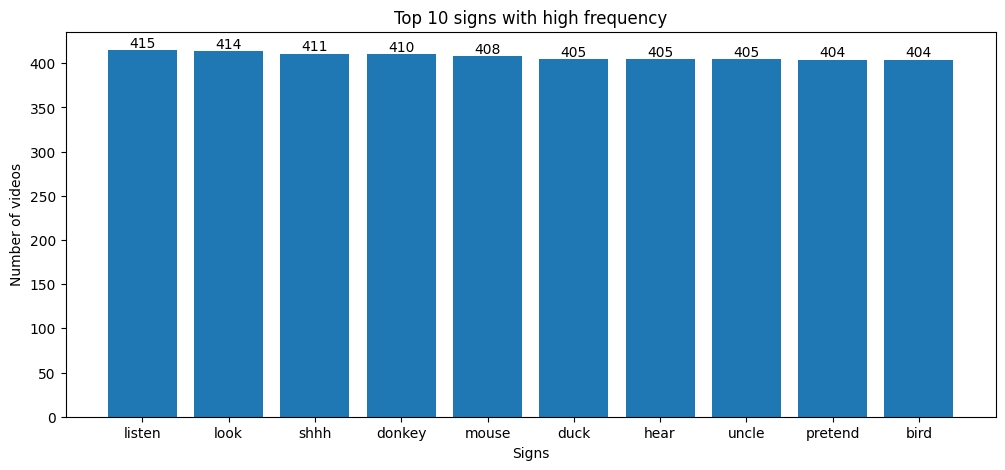

In [22]:
sign_counts = train_df['sign'].value_counts().head(20)  ## Top 20 signs with highest frequency
plt.figure(figsize=(15,6))
plt.bar(sign_counts.index, sign_counts.values)
plt.title("Top 10 signs with high frequency")
plt.xlabel("Signs")
plt.ylabel("Number of videos")

for i, v in enumerate(sign_counts.values):
    plt.text(i, v, str(v), ha='center', va='bottom')
    
plt.show()

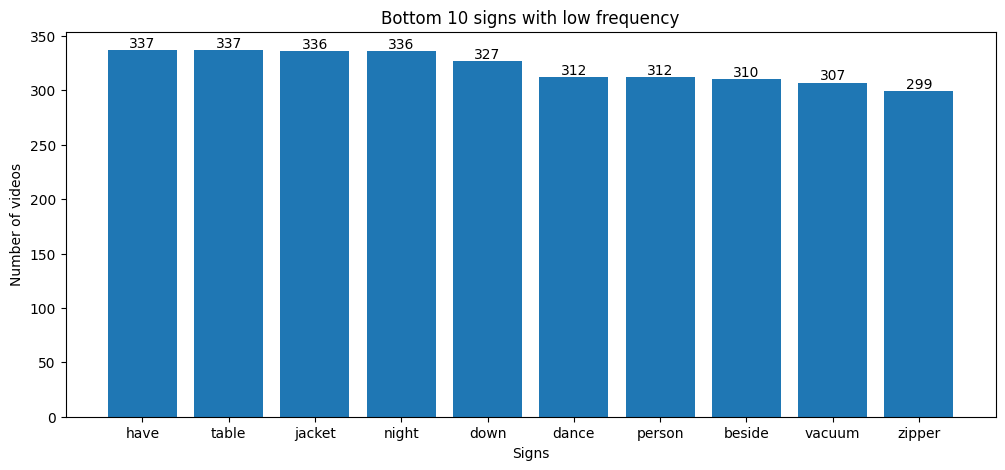

In [23]:
sign_counts_low = train_df['sign'].value_counts().tail(20)  ## Bottom 10 signs with low frequency
plt.figure(figsize=(15,6))
plt.bar(sign_counts_low.index, sign_counts_low.values)
plt.title("Bottom 10 signs with low frequency")
plt.xlabel("Signs")
plt.ylabel("Number of videos")

for i, v in enumerate(sign_counts_low.values):
    plt.text(i, v, str(v), ha='center', va='bottom')
    
plt.show()

In [24]:
## finding the video with max frames 
frames = []

for i in tqdm(range(len(train_df))):
    pq_path = os.path.join('/kaggle/input/asl-signs',train_df['path'][i])
    pq_df = pd.read_parquet(pq_path)
    n_frames = len(pq_df['frame'].unique())
    frames.append(n_frames)

max(frames)

100%|██████████| 94477/94477 [45:39<00:00, 34.49it/s]  


537

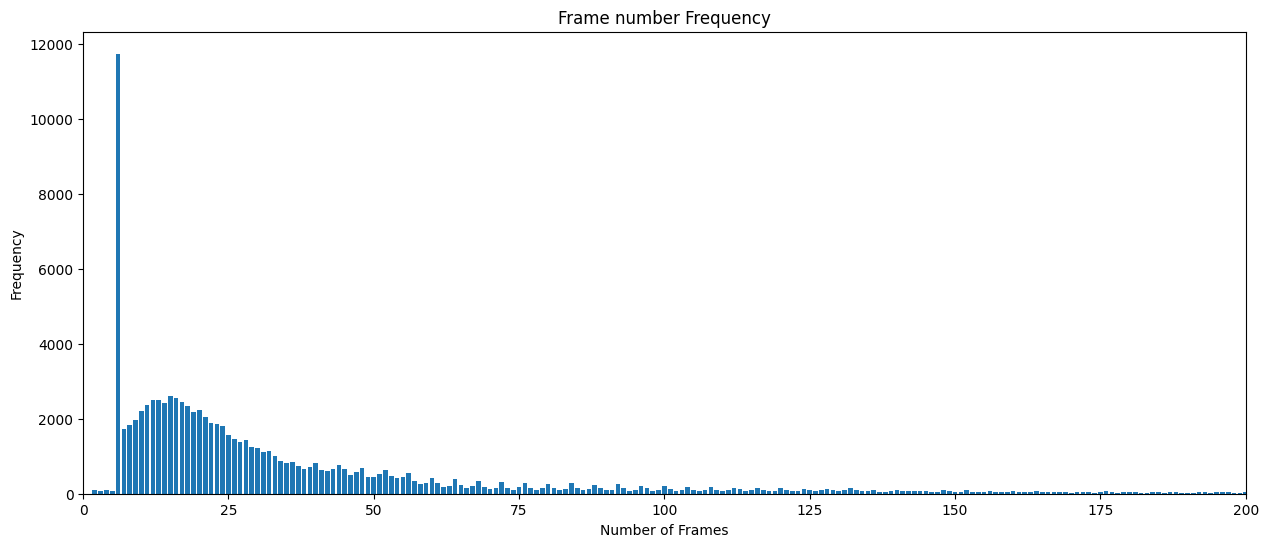

In [32]:
from collections import Counter
freq = Counter(frames)

# Create lists of the x and y values for the plot
x = list(freq.keys())
y = list(freq.values())

plt.figure(figsize=(15,6))
# Plot the values as a bar graph
plt.bar(x, y)

# Add labels to the plot
plt.title("Frame number Frequency")
plt.xlabel("Number of Frames")
plt.ylabel("Number of Videos")
plt.xlim(0,200)

# Display the plot
plt.show()

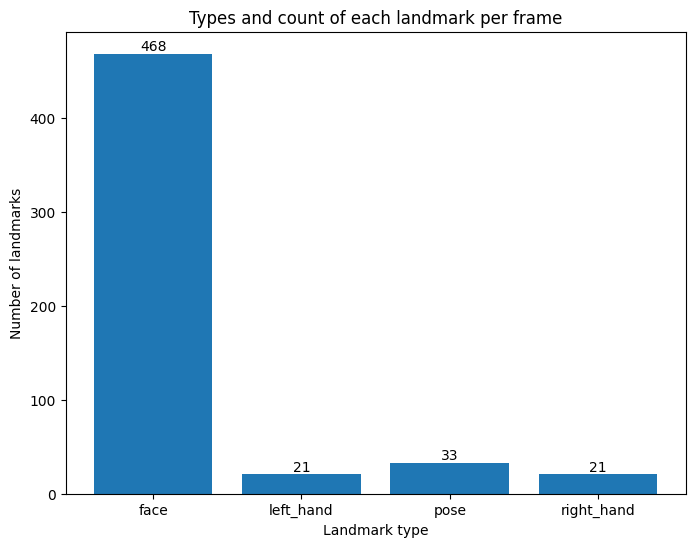

In [11]:
landmark_count = pq_df[pq_df['frame']==20].groupby('type')['landmark_index'].count()  ## for one frame finding the landmark data

plt.figure(figsize=(8,6))
plt.bar(landmark_count.index, landmark_count.values)
plt.title("Types and count of each landmark per frame")
plt.xlabel("Landmark type")
plt.ylabel("Number of landmarks")

for i, v in enumerate(landmark_count.values):
    plt.text(i, v, str(v), ha='center', va='bottom')
    
plt.show()

In [11]:
import mediapipe as mp

def show_landmarks(pq_dataset, frame_number, label):
    pq_df["y_"] = pq_df["y"] * -1

    fig, ax = plt.subplots(figsize=(5, 7))

    for landmark in ["left_hand", "right_hand",'face','pose']:
        example_hand = pq_df[pq_df['frame'] == frame_number]
        example_hand = example_hand[example_hand['type'] == landmark]
        ax.scatter(example_hand["x"], example_hand["y_"])

        if landmark in ['left_hand','right_hand']:
            for connection in mp.solutions.hands.HAND_CONNECTIONS:
                point_a = connection[0]
                point_b = connection[1]
                x1, y1= example_hand[example_hand['landmark_index'] == point_a][["x", "y_"]].values[0]
                x2, y2 = example_hand[example_hand['landmark_index'] == point_b][["x", "y_"]].values[0]
                plt.plot([x1, x2], [y1, y2], color="black")

        if landmark=='face':
            for connection in mp.solutions.face_mesh_connections.FACEMESH_FACE_OVAL:
                point_a = connection[0]
                point_b = connection[1]
                x1, y1= example_hand[example_hand['landmark_index'] == point_a][["x", "y_"]].values[0]
                x2, y2 = example_hand[example_hand['landmark_index'] == point_b][["x", "y_"]].values[0]
                plt.plot([x1, x2], [y1, y2], color="red")

        if landmark=='pose':
            for connection in mp.solutions.pose.POSE_CONNECTIONS:
                point_a = connection[0]
                point_b = connection[1]
                x1, y1= example_hand[example_hand['landmark_index'] == point_a][["x", "y_"]].values[0]
                x2, y2 = example_hand[example_hand['landmark_index'] == point_b][["x", "y_"]].values[0]
                plt.plot([x1, x2], [y1, y2], color="purple")

    ax.set_title(f'{label} sign - landmarks data')
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    plt.show()

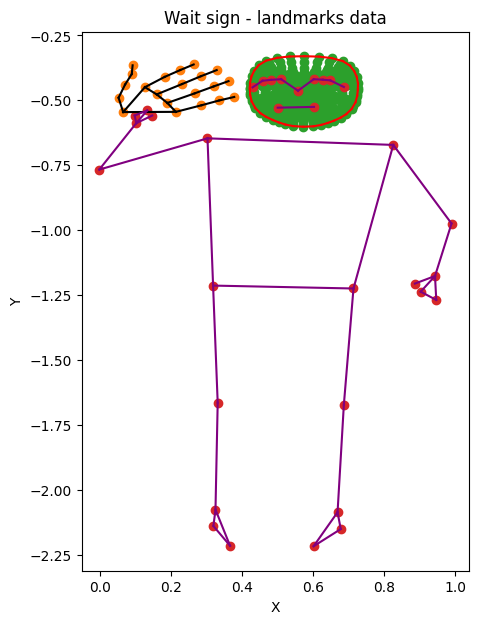

In [12]:
pq_path = os.path.join('/kaggle/input/asl-signs',train_df['path'][1])  
pq_df = pd.read_parquet(pq_path)
show_landmarks(pq_df, 29,'Wait')

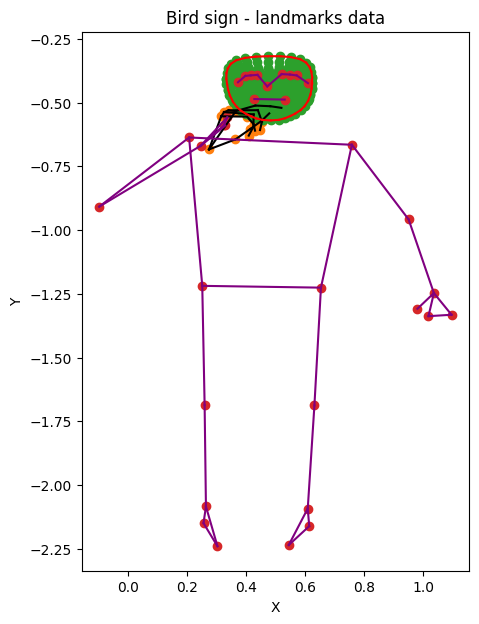

In [14]:
pq_path = os.path.join('/kaggle/input/asl-signs',train_df['path'][3])   
pq_df = pd.read_parquet(pq_path)
show_landmarks(pq_df,20,'Bird')

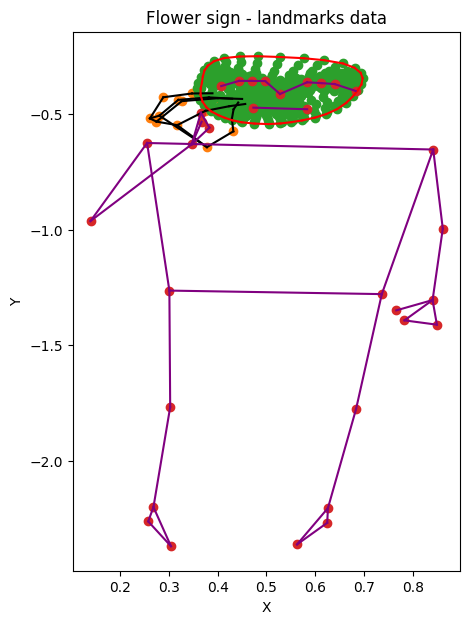

In [28]:
pq_path = os.path.join('/kaggle/input/asl-signs',train_df['path'][94474])   
pq_df = pd.read_parquet(pq_path)
show_landmarks(pq_df, 21,'Flower')